In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [152]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username/password, and connection specifics
#username = 'usernama'
#password = ''pwd     # change this
#host     = 'localhost'
#port     = '5432'            # default port that postgres listens on
#db_name  = 'MB_db'

In [4]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
#engine = create_engine( 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host, port, db_name) )
#print(engine.url)

Before running the commands below, initiate SQL server from a terminal by:<br>
sudo service postgresql start<br>
sudo service postgresql status<br>
(sudo passwd postgres) - set a password for postgres: one-time thing<br>
su postgres<br>

In [5]:
# for now not using this, as 
#if not database_exists(engine.url):
#    create_database(engine.url)
#print(database_exists(engine.url))

In [6]:
import json

In [7]:
data = []
# MB Masters 2017 run using 11k data
#for line in open('problems.txt', 'r'):
#MB 2016 run using 19k data
for line in open('problems_2016.txt', 'r'):
    data.append(json.loads(line))
# This creates a list of json-problems: to load this with sql, cast it to dataframe

In [8]:
# sanity check: Is the data well read?
print(data[1])

{'Method': 'Feet follow hands', 'Name': 'COUCH PROBLEM', 'Grade': '7A+', 'UserGrade': None, 'MoonBoardConfiguration': None, 'MoonBoardConfigurationId': 0, 'Setter': {'Id': '90FEA433-70AA-41AB-B93A-B3F30037E218', 'Nickname': 'marcel aarden', 'Firstname': 'marcel', 'Lastname': 'aarden', 'City': 'victoria', 'Country': 'CANADA', 'ProfileImageUrl': '/Content/Account/Images/default-profile.png?636728751296147425', 'CanShareData': True}, 'FirstAscender': False, 'Rating': 0, 'UserRating': 0, 'Repeats': 0, 'Attempts': 0, 'Holdsetup': {'Id': 1, 'Description': 'MoonBoard 2016', 'Setby': None, 'DateInserted': None, 'DateUpdated': None, 'DateDeleted': None, 'IsLocked': False, 'Holdsets': None, 'MoonBoardConfigurations': None, 'HoldLayoutId': 0, 'AllowClimbMethods': False}, 'IsBenchmark': False, 'IsAssessmentProblem': False, 'ProblemType': None, 'Moves': [{'Id': 1790343, 'Description': 'K5', 'IsStart': True, 'IsEnd': False}, {'Id': 1790344, 'Description': 'K8', 'IsStart': False, 'IsEnd': False}, {'I

In [9]:
# read a database from CSV and load it into a pandas dataframe : 
# birdh_data = pd.read_csv('births2012_downsampled.csv', index_col=0)

In [10]:
# reading data in python : good for performance comparison, but we don't need it
## insert data into database from Python (proof of concept - this won't be useful for big data, of course)
problems_raw = pd.DataFrame(data)
# MB2017
# problems = problems_raw.loc[problems_raw['Grade']!='6A+']
# MB2016
problems = problems_raw.loc[problems_raw['Grade']!='6B+']
problems = problems.reset_index()
#problems.to_sql('MB_prob_table', engine, if_exists='replace')

In [11]:
# Let's implement SQL part later, and focus on DataFrame for now. The data would not be that big in the end!
#con = None
#con = psycopg2.connect(database = db_name, user = username, password=password)

# created a symbolic link in /tmp/ to /var/run/postgresql/
# password supplied to psycopg2

# query:
#sql_query = """
#SELECT * FROM birth_data_table WHERE delivery_method='Cesarean';
#"""
#birth_data_from_sql = pd.read_sql_query(sql_query,con)
#birth_data_from_sql.head()

In [12]:
import seaborn as sns

In [13]:
font = ['5+','6A','6A+','6B','6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A','8A+','8B','8B+']
vgrd = [2,3,3,4,4,5,5,6,7,8,8,9,10,11,12,13,14]
print(len(font))
print((vgrd))

17
[2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14]


In [14]:
grade_conversion = dict(zip(font,vgrd))

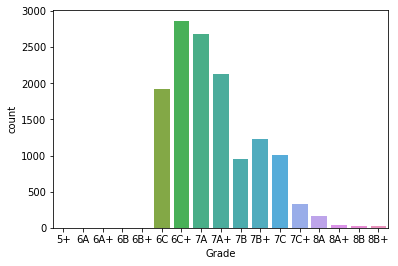

In [15]:
%matplotlib inline
sns.countplot(x="Grade", data=problems, order=['5+','6A','6A+','6B','6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A','8A+','8B','8B+'])
# model: two lognormal with 6A+ being faulty data collection?
# since the grades are ordinal, may I model it as lognormal...?
# Why a dip at 7B and not so obvious excess at 6B+? Is there any reason to believe that
# especially 7B route setters are more likely to estimate the grade wrong?

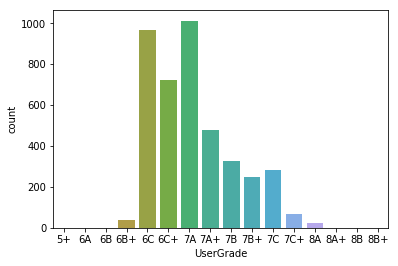

In [16]:
sns.countplot(x="UserGrade", data=problems, order=['5+','6A','6B','6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A','8A+','8B','8B+'])
# can this be accounted as a "real" distribution of grades 
# (since this means other users cared enough to grade the ther's problem)? 
# It does look log-normal! :P
# fit log-normal and use the param as the "ideal" grade distribution?

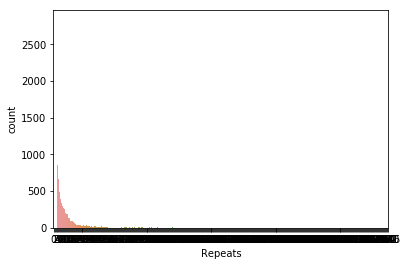

In [17]:
sns.countplot(x="Repeats", data=problems)

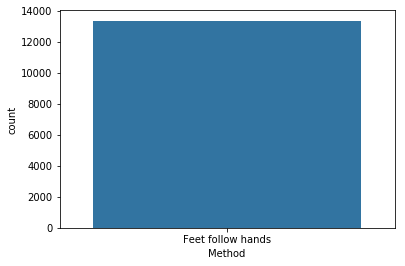

In [18]:
sns.countplot(x="Method", data=problems)

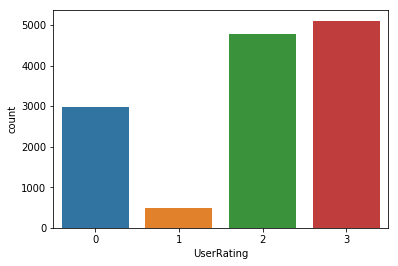

In [19]:
sns.countplot(x="UserRating", data=problems)

In [20]:
# additional feature engineering : distances between holds?
def alphabet_to_num(char):
    return ord(char.lower()) - 96
def split_xy(string):
    import re
    r = re.compile("([a-zA-Z]+)([0-9]+)")
    #strings = ['foofo21', 'bar432', 'foobar12345']
    return list(r.match(string).groups())
def distance(hold1, hold2):
    coord1 = split_xy(hold1)
    coord1 = np.array([int(alphabet_to_num(coord1[0])),int(coord1[1])])
    coord2 = split_xy(hold2)
    coord2 = np.array([int(alphabet_to_num(coord2[0])),int(coord2[1])])
    return np.linalg.norm(coord1-coord2)

In [81]:
#num_to_alphabet(2)

'B'

In [21]:
length = [len((problems['Moves'][i])) for i in range(len(problems))]

In [22]:
problems['Length'] = pd.Series(length)

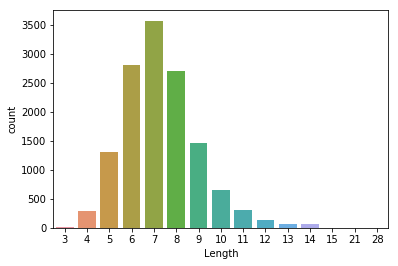

In [23]:
sns.countplot(x='Length', data=problems)

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


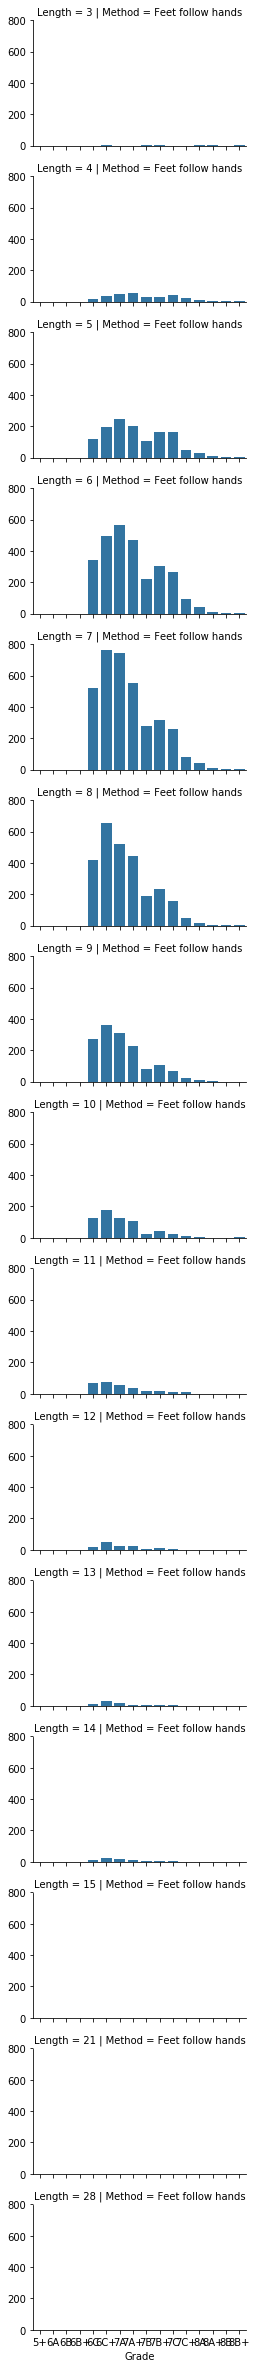

In [24]:
grid = sns.FacetGrid(data = problems, col='Method', row='Length', size=2.2, aspect=1.6)
grid.map(sns.countplot, 'Grade', order=['5+','6A','6B','6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A','8A+','8B','8B+'])
grid.add_legend();

In [25]:
print(problems['Moves'][0][0])
print(problems['Moves'][0][0]['Description'])
holds = []
for i in range(len(problems)):
    holds.append([problems['Moves'][i][j]['Description'] for j in range(problems['Length'][i])])

{'Id': 1790368, 'Description': 'B3', 'IsStart': True, 'IsEnd': False}
B3


In [26]:
print(holds[0])

['B3', 'A5', 'G8', 'E7', 'C10', 'D12', 'D15', 'G15', 'G17', 'G18']


In [27]:
def xlims(list):
    # return (leftmost, rightmost) x coordinate of a given problem
    n = len(list)
    coords = [alphabet_to_num(split_xy(list[i])[0]) for i in range(n)]
#    xcoords = [coords[i][0] for i in range(n)]
#    xcoords = [alphabet_to_num(coords[i]) for i in range(n)]
    return [min(coords),max(coords)]

In [28]:
xlims(holds[0])

[1, 7]

In [29]:
df_holds = pd.Series(holds)
#df_holds.head(5)

0    [B3, A5, G8, E7, C10, D12, D15, G15, G17, G18]
1                 [K5, K8, H10, B11, B15, A15, A18]
2                  [F5, J5, G9, E12, J13, H16, I18]
3         [D3, C5, E8, A9, E12, D11, H14, E16, E18]
4     [G2, I4, F7, I8, I9, E10, F13, H14, G17, I18]
dtype: object

In [30]:
a = df_holds.apply(xlims)
b = pd.DataFrame(a,columns=['lr'])
b[['l','r']] = pd.DataFrame(b.lr.values.tolist(), index= b.index)
b = b.drop(['lr'],axis=1)
b['width'] = b['r']-b['l']
#b.head(5)

,l,r,width
0,1,7,6
1,1,11,10
2,5,10,5
3,1,8,7
4,5,9,4


In [31]:
b['width'] = b['r']-b['l']

In [90]:
# generate classes for mlb!
mlb_class = []
for i in range(11):
    for j in range(18):
        mlb_class.append(chr(i+65)+'%d'%(j+1))

In [91]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=mlb_class)
df_holds_enc = pd.DataFrame(mlb.fit_transform(df_holds), columns=mlb_class)
#df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('Col3')),
#                          columns=mlb.classes_,
#                          index=df.index))

In [92]:
# feature vector: hold positions multilabel binary encoded
df_holds_enc = df_holds_enc.join(problems['Length'])
df_holds_enc = df_holds_enc.join(b)

df_holds_enc.tail(5)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,K13,K14,K15,K16,K17,K18,Length,l,r,width
13355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,4,10,6
13356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,3,6,3
13357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,5,11,6
13358,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,6,1,6,5
13359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,2,10,8


In [93]:
# add width of problems (max(x)-min(x)) to the features
# leftmost hold

In [94]:
labels = problems['Grade']

In [95]:
v_labels = problems.replace({'Grade': grade_conversion})['Grade']

Text(0,0.5,'')

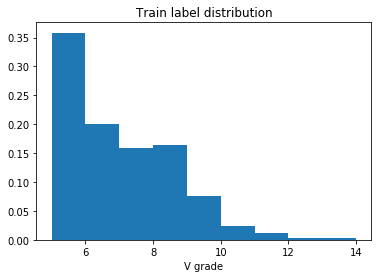

In [179]:
plt.hist(v_labels,bins= range(min(v_labels),max(v_labels)+1),density=True)
plt.title('Train label distribution')
plt.xlabel('V grade')
# IF the classifier classifies everything to 5, the accuracy will be 35%

In [97]:
print(labels.head(5))
print(v_labels.head(5))
print(min(v_labels),max(v_labels))

0     7A
1    7A+
2    6C+
3    6C+
4    6C+
Name: Grade, dtype: object
0    6
1    7
2    5
3    5
4    5
Name: Grade, dtype: int64
5 14


In [98]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df_holds_enc, v_labels, test_size = 0.25, random_state = 42)

In [99]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (10020, 202)
Training Labels Shape: (10020,)
Testing Features Shape: (3340, 202)
Testing Labels Shape: (3340,)


In [100]:
print(train_features.head(5))

       A1  A2  A3  A4  A5  A6  A7  A8  A9  A10  ...    K13  K14  K15  K16  \
7757    0   0   0   0   0   0   0   0   0    0  ...      0    0    0    0   
1284    0   0   0   0   0   0   0   0   0    0  ...      0    0    0    0   
4604    0   0   0   0   0   0   0   0   0    0  ...      0    0    0    0   
11228   0   0   0   0   0   0   0   0   0    0  ...      0    0    0    0   
6388    0   0   0   0   0   0   0   0   0    0  ...      0    0    0    0   

       K17  K18  Length  l   r  width  
7757     0    0      10  5  11      6  
1284     0    0       6  4   8      4  
4604     0    0       6  7  11      4  
11228    0    0       6  6  11      5  
6388     0    0       6  3   9      6  

[5 rows x 202 columns]


In [101]:
from sklearn.metrics import precision_score

In [102]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [165]:
features_name = train_features.columns.values.tolist()

Feature ranking:
1. feature 198 (0.052663)
2. feature 201 (0.042181)
3. feature 199 (0.032412)
4. feature 200 (0.031688)
5. feature 94 (0.014076)
6. feature 109 (0.012917)
7. feature 71 (0.011858)
8. feature 125 (0.010983)
9. feature 89 (0.010894)
10. feature 79 (0.010623)
11. feature 99 (0.010369)
12. feature 161 (0.010032)
13. feature 111 (0.009828)
14. feature 135 (0.009819)
15. feature 56 (0.009351)
16. feature 104 (0.009313)
17. feature 83 (0.009249)
18. feature 130 (0.009233)
19. feature 85 (0.009173)
20. feature 86 (0.009151)
21. feature 100 (0.008891)
22. feature 166 (0.008626)
23. feature 121 (0.008572)
24. feature 102 (0.008497)
25. feature 133 (0.008413)
26. feature 77 (0.008392)
27. feature 48 (0.008371)
28. feature 136 (0.008371)
29. feature 63 (0.008343)
30. feature 20 (0.008248)
31. feature 84 (0.008195)
32. feature 40 (0.008194)
33. feature 139 (0.008155)
34. feature 116 (0.008113)
35. feature 141 (0.007884)
36. feature 157 (0.007828)
37. feature 87 (0.007805)
38. featu

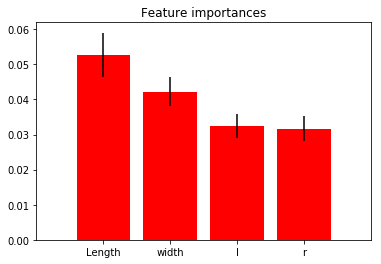

In [175]:
# let's plot feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
top4_indices = indices[:4]
# Print the feature ranking
print("Feature ranking:")

for f in range(train_features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
lbl = tuple([features_name[top4_indices[i]] for i in range(4)])
print(lbl)
# Plot the feature importances of the forest
#plt.bar(range(train_features.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
#plt.title("Feature importances")
#plt.xticks(range(train_features.shape[1]), indices)
#plt.xlim([-1, train_features.shape[1]])
# Plot the feature importances of the forest
plt.bar(range(4), importances[top4_indices],
       color="r", yerr=std[top4_indices], align="center")
plt.title("Feature importances")
plt.xticks(range(4), lbl)
plt.xlim([-1, 4])
plt.show()

In [103]:
pred_probability = rf.predict_proba(test_features)

In [155]:
# save the model to disk
filename = 'RF_model.sav'
pickle.dump(rf, open(filename, 'wb'))

Text(0.5,1,'Real Grade : 8')

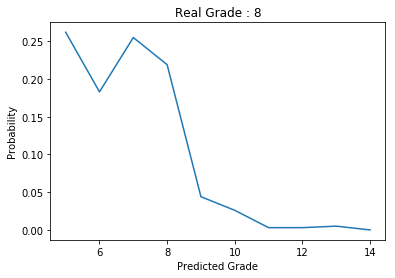

In [134]:
#import matplotlib.pyplot as plt
prob_num = 76
real_grade = np.array(test_labels)
plt.plot(range(min(v_labels),max(v_labels)+1),pred_probability[prob_num])
plt.xlabel('Predicted Grade')
plt.ylabel('Probability')
plt.title('Real Grade : %d'%(real_grade[prob_num]))
# plot probability distribution of each predictions
# 45 is an example of good classification
# 90 has two peaks... 
# ways to quantify this? difference between two peaks should be more than 0.3?
# what about more wide distribution?

In [105]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.98 degrees.


Text(0.5,0,'V grade')

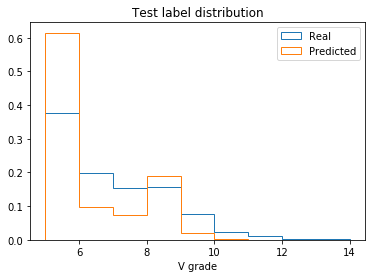

In [187]:
plt.hist(test_labels, bins= range(min(v_labels),max(v_labels)+1), density=True, histtype='step',label='Real')
plt.hist(predictions, bins= range(min(v_labels),max(v_labels)+1), density=True, histtype='step',label='Predicted')
plt.title('Test label distribution')
plt.legend(loc='upper right')
plt.xlabel('V grade')

In [107]:
print(predictions)

[5 5 5 ... 6 8 7]


[ 0  0  0 ... -1  3 -1]
0.4359281437125748


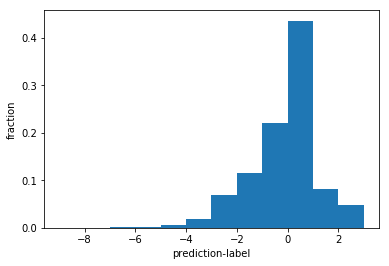

In [176]:
pred = np.array(predictions)
tlabel = np.array(test_labels)
tst = pred-tlabel
print(tst)
binwidth=1
plt.hist(tst,bins=range(min(tst),max(tst),binwidth),density=True)
plt.xlabel('prediction-label')
plt.ylabel('fraction')
print((len(tst)-np.count_nonzero(tst))/len(tst))
# 38% accuracy (exact classification)
# Classifier tend to classify problems easier than it actually is: prob because not many hard problems exist

In [109]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
# by removing 6A+, the accuracy improves from 76 to 78%
# by adding length, 78 to 79%
# RFclassifier -> 80.3%
# why was the stanford group's accuracy so low? -> because they only looked at rate at which 
# they actually got the label correct
# LET'S IMPLEMENT IMBALANCE LEARNING

Accuracy: 86.48 %.


In [110]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(train_features, train_labels)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(5, 3532), (6, 3532), (7, 3532), (8, 3532), (9, 3532), (10, 3532), (11, 3532), (12, 3532), (13, 3532), (14, 3532)]


In [111]:
rf2 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf2.fit(X_resampled, y_resampled)
pred_probability2 = rf2.predict_proba(test_features)
predictions2 = rf2.predict(test_features)

In [112]:
print(rf2.score(test_features, test_labels))
print(precision_score(test_labels, predictions2, average=None))

0.43233532934131735
[0.57438479 0.25961538 0.26807229 0.28031496 0.26119403 0.18181818
 0.3        0.         0.         0.        ]


/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,1,'Real Grade : 8')

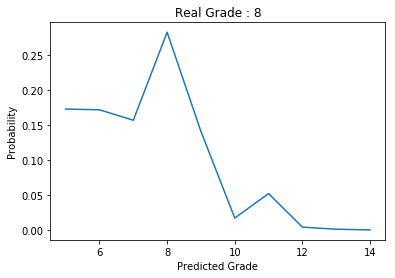

In [113]:
#import matplotlib.pyplot as plt
prob_num = 723
real_grade = np.array(test_labels)
plt.plot(range(min(v_labels),max(v_labels)+1),pred_probability2[prob_num])
plt.xlabel('Predicted Grade')
plt.ylabel('Probability')
plt.title('Real Grade : %d'%(real_grade[prob_num]))
# plot probability distribution of each predictions
# 45 is an example of good peak but is off by the true label :P
# 90, 579 is a good classification! :D
# 710 has three peaks :P
# 951 matches
# ways to quantify this? difference between two peaks should be more than 0.3?
# what about more wide distribution?

[ 1  0  0 ... -1  4 -1]
0.43233532934131735


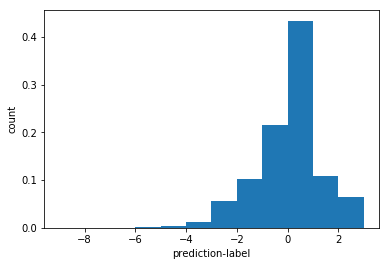

In [114]:
pred2 = np.array(predictions2)
tst2 = pred2-tlabel
print(tst2)
binwidth=1
plt.hist(tst2,bins=range(min(tst),max(tst),binwidth),density=True)
plt.xlabel('prediction-label')
plt.ylabel('count')
print((len(tst2)-np.count_nonzero(tst2))/len(tst2))
# 38.5% accuracy (exact classification)

In [115]:
# implement a function that take input data as 2d coordinates (list), process it by doing mlb transformation 
# + count, left, right, to make it the same format as train / test data. 
# Run it through the RF model, return the expected grade, probability of difficulty
def input_to_output(list):
    h_enc = mlb.transform([list])
    h_enc = pd.DataFrame(h_enc,columns=mlb.classes_)
    tmp = xlims(list)
    tmp = {'lr':[tmp]}
    tmp2 = pd.DataFrame.from_dict(tmp)
    tmp2[['l','r']] = pd.DataFrame(tmp2.lr.values.tolist(), index= tmp2.index)
    tmp2 = tmp2.drop(['lr'],axis=1)
    h_enc['Length'] = pd.Series(len(list))
    h_enc = h_enc.join(tmp2)
    h_enc['width'] = h_enc['r']-h_enc['l']
    prob = rf2.predict_proba(h_enc)
    plt.plot(range(min(v_labels),max(v_labels)+1),prob[0])
    return [rf2.predict(h_enc),rf2.predict_proba(h_enc)]

In [154]:
# save the model to disk
filename = 'RF_imbmodel.sav'
pickle.dump(rf2, open(filename, 'wb'))

[array([8]),
 array([[0.09 , 0.193, 0.205, 0.27 , 0.182, 0.055, 0.005, 0.   , 0.   ,
         0.   ]])]

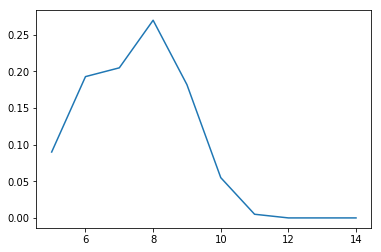

In [116]:
input_to_output(['A1','B5','C9','D13','E17','F18'])

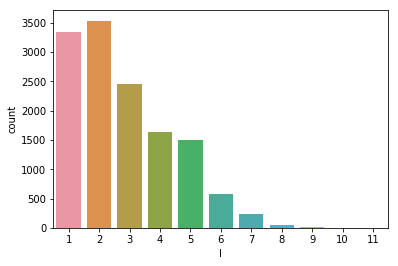

In [117]:
sns.countplot(x='l', data=df_holds_enc)

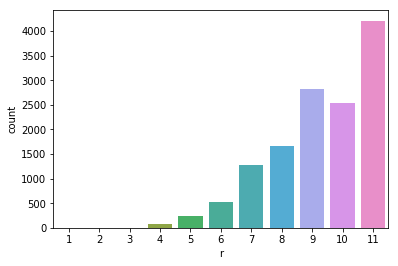

In [118]:
sns.countplot(x='r', data=df_holds_enc)

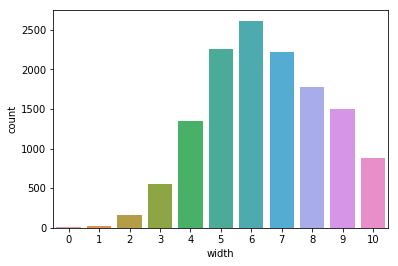

In [119]:
sns.countplot(x='width', data=df_holds_enc)

In [ ]:
input_to_output()

In [131]:
# function creating a clickable grid (11 x 18) and return the coordinate clicked
import tkinter as tk

def click(row, col):
    label.configure(text="you clicked %s%s" % ( chr(col+65),row+1))

root = tk.Tk()
for col in range(11):
    for row in range(18):
        button = tk.Button(root, text="%s%s" % (chr(col+65), row+1), 
                           command=lambda row=19-row, col=col: click(19-row, col))
        button.grid(row=19-row, column=col, sticky="nsew")
label = tk.Label(root, text="")
label.grid(row=20, column=0, columnspan=11, sticky="new")

root.grid_rowconfigure(18, weight=1)
root.grid_columnconfigure(11, weight=1)

root.mainloop()